# Diabetes Classification Project

For our second data science project, we have chosen a very relevant and important subject: Diabetes. Diabetes is a growing global phenomenon, and it has the potential to be as dangerous as it is prevalent. In fact, it is a leading cause of death worldwide, and mismanaged diabetes is a leading cause to blindness, amputations, kidney failure, heart disease, and other tragic chronic illnesses/disabilities. Though the manifestation of diabetes has a strong genetic factor, Type 2 diabetes (the type of diabetes that develops at a later stage of life) can be prevented, and if it occurs, can be well-managed.

Therefore, knowing the factors that are correlated with Diabetes is very helpful in realizing that one may be in a risk group and should take precautionary measures to prevent Diabetes; and thus, this classification task serves us in both data science knowledge and very important health knowledge. For this task, our target will be the existence of Diabetes in an instance (the 'Outcome' column), and the classification will be based upon the other features of each instance.

# Procedure:

1. Cleaning the Data and Feature Engineering
2. Visualizing/Getting to Know Our Data
3. Testing Different Models
4. Fine-Tuning our Models
5. Finally: Testing our Best Model

# Cleaning the Data & Feature Engineering

In [27]:
# First, let's import the necessary tools to proceed and load our datatset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


from sklearn.dummy import DummyClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve



In [23]:
# Let's take a look at our data, shall we?

df = pd.read_csv('diabetes.csv')

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
# let's look into the details of each column, to look for null-values and to see the type of type per feature.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# let's take a deeper look at the blood pressure column

df['BloodPressure'].min()

0

Here, we noticed that we have an impossible minimum value: 0. It is clear that every 0 value should be treated as a null instance. We decided to solve this problem by filling all 0 values with the mean Blood Pressure.

In [6]:
blood_pressure_exist = df[df['BloodPressure']!=0]
blood_pressure_exist =blood_pressure_exist['BloodPressure']
df['BloodPressure']=df['BloodPressure'].apply(lambda x:int(blood_pressure_exist.mean()) if x==0 else x)
df['BloodPressure']

0      72
1      66
2      64
3      66
4      40
       ..
763    76
764    70
765    72
766    60
767    70
Name: BloodPressure, Length: 768, dtype: int64

Furthermore, we decided to feature engineer another feature from the Blood Pressure feature: we will create a column that categorizes an instance as high blood pressure or not, as diabetes and high blood pressure often occur together and the existence of one of these conditions can exacerbate the other (2 in 3 diabetic people have high blood pressure). 


Diastolic pressure above 80 is considered high blood pressure, and therefore, for every instance that has an 80 or above blood pressure, we will categorize as having high blood pressure.

In [7]:
df['High_BloodPressure']=df['BloodPressure'].apply(lambda x:1 if x>=80 else 0)
df['High_BloodPressure'].value_counts()

0    563
1    205
Name: High_BloodPressure, dtype: int64

We have noticed that yet another feature of ours has an impossible value of 0: BMI, and therefore we will treat a BMI of 0 as a null value. We decided to solve this problem by filling all 0 values with the median BMI.

In [8]:
bmi_noNull=df[df['BMI']!=0]
bmi_noNull['BMI'].median()
df['BMI']=df['BMI'].apply(lambda x:bmi_noNull['BMI'].median() if x==0 else x)
df['BMI']

0      33.6
1      26.6
2      23.3
3      28.1
4      43.1
       ... 
763    32.9
764    36.8
765    26.2
766    30.1
767    30.4
Name: BMI, Length: 768, dtype: float64

Furthermore, we have decided to feature engineer another feature from our BMI feature: a feature which categorized Weight ('Weight'): 'underweight' (BMI of 18.5 or less), 'healthy weight' (BMI 18 to 30, not including 30) and 'obese' (a BMI of 30 and above).
This feature could be of great importance, as obesity accounts for 80-85% of the risk of developing Type 2 diabetes; whereas Healthy Weight and Underweight may help distinguish the non-diabetic people apart from the diabetic people.

In [9]:
def find_weight(position):
    if position<18.5:
        return 'UnderWeight'
    elif position>=18.5 and position<30:
        return 'Healthy'
    else :
        return 'Obese'
    
df['Weight']=df['BMI'].apply(find_weight)
df['Weight'].value_counts()

Obese          483
Healthy        281
UnderWeight      4
Name: Weight, dtype: int64

We have noticed that once again we have another feature which has an impossible value of 0: Glucose levels. We decided to solve this problem by filling all 0 values with the mean Glucose value.

In [12]:
glucose_no_zero=df[df['Glucose']!=0]

df['Glucose']=df['Glucose'].apply(lambda x:int(glucose_no_zero['Glucose'].mean()) if x==0 else x)

Furthermore, we have decided to feature engineer a feature through the Glucose feature: Glucose Level. Normal blood glucose level (tested while fasting) for non-diabetics is between 3.9 and 7.1 mmol/L (70 and 130 mg/dL), and therefore, we will consider anything below 70 as low and anything above 130 as high. There is great significance to this feature as Glucose Level is the diagnostic measure of diabetes; high glucose levels is a sign of diabetes.

In [14]:
def define_glucose_level(position):
    if position<70:
        return 'low_glucose_levels'
    elif position>=130:
        return 'high_glucose_levels'
    else:
        return 'normal_glucose_levels'
    
df['Glucose_Level']=df['Glucose'].apply(define_glucose_level)
df['Glucose_Level'].value_counts()

normal_glucose_levels    499
high_glucose_levels      258
low_glucose_levels        11
Name: Glucose_Level, dtype: int64

Yet another feature we have decided to engineer is a feature that accounts for elderly instances; as Type 2 diabetes has a later onset, and is quite common in elderly people. We will set anyone who is 65 years old or older as elderly.

In [10]:
df['Elderly']=df['Age'].apply(lambda x:1 if x>=65 else 0)
df['Elderly'].value_counts()

0    752
1     16
Name: Elderly, dtype: int64

We have noticed another feature in which has an impossible value of 0: Skin Thicnkess. 
This box plot of the distribution reveals that there is a great amount of instances in which Skin Thickness was set at this null 0 value:

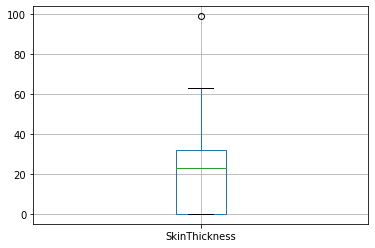

In [15]:
df.boxplot(column=['SkinThickness'])

Therefore, to counteract this, we will set the null 0 values with the most frequently occuring value (other than 0), and that would be 32.

In [16]:
skin_thickness_without=df[df['SkinThickness']!=0]

print(skin_thickness_without['SkinThickness'].mode())

df['SkinThickness']=df['SkinThickness'].apply(lambda x:32 if x==0 else x)
df['SkinThickness']

0    32
dtype: int64


0      35
1      29
2      32
3      23
4      35
       ..
763    48
764    27
765    23
766    32
767    31
Name: SkinThickness, Length: 768, dtype: int64

We have decided to engineer a feature from the SkinThickness feature: SkinThickness levels. We have divided it into 10 levels.
This feature is indeed relevant as high skin thickness is greatly related to the existence of diabetes.

In [17]:
def thickness_level(position):
    if position<=10:
        return 1
    elif position<=20:
        return 2
    elif position<=30:
        return 3
    elif position<=40:
        return 4
    elif position<=50:
        return 5
    elif position<=60:
        return 6
    elif position<=70:
        return 7
    elif position<=80:
        return 8
    elif position<=90:
        return 9
    else:
        return 10
    
df['Thickness_level']=df['SkinThickness'].apply(thickness_level)
df['Thickness_level'].value_counts()

4     391
3     179
2     115
5      65
1       9
6       7
10      1
7       1
Name: Thickness_level, dtype: int64

Finally, we have noticed that Insulin, too, has impossible values of 0. Let's look at its distribution:

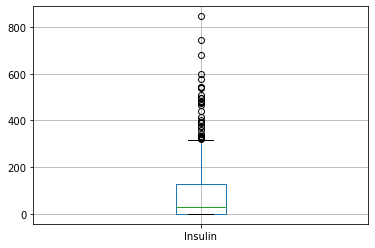

In [18]:
df.boxplot(column=['Insulin'])

Due to the high amount of outliers, we have decided to solve the issue of the null 0 values by filling those values with the median Insulin value (as opposed to the mean) to avoid getting a skewed value.

In [19]:
insulin_without_zero=df[df['Insulin']!=0]
insulin_without_zero['Insulin'].median()
df['Insulin']=df['Insulin'].apply(lambda x:insulin_without_zero['Insulin'].median() if x==0 else x)
df['Insulin']

0      125.0
1      125.0
2      125.0
3       94.0
4      168.0
       ...  
763    180.0
764    125.0
765    112.0
766    125.0
767    125.0
Name: Insulin, Length: 768, dtype: float64

In [20]:
# our final cleaned dataset

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,High_BloodPressure,Weight,Elderly,Glucose_Level,Thickness_level
0,6,148,72,35,125.0,33.6,0.627,50,1,0,Obese,0,high_glucose_levels,4
1,1,85,66,29,125.0,26.6,0.351,31,0,0,Healthy,0,normal_glucose_levels,3
2,8,183,64,32,125.0,23.3,0.672,32,1,0,Healthy,0,high_glucose_levels,4
3,1,89,66,23,94.0,28.1,0.167,21,0,0,Healthy,0,normal_glucose_levels,3
4,0,137,40,35,168.0,43.1,2.288,33,1,0,Obese,0,high_glucose_levels,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.0,32.9,0.171,63,0,0,Obese,0,normal_glucose_levels,5
764,2,122,70,27,125.0,36.8,0.340,27,0,0,Obese,0,normal_glucose_levels,3
765,5,121,72,23,112.0,26.2,0.245,30,0,0,Healthy,0,normal_glucose_levels,3
766,1,126,60,32,125.0,30.1,0.349,47,1,0,Obese,0,normal_glucose_levels,4


We saved our clean dataset into this file:

df.to_csv('Cleaned_Diabetes.csv')

# Visualizing / Getting to Know Our Data

How can we secure that there is no data leakage? So as to ensure that our model's performance is reliable, there is a need to prevent any data leakage, or else we will not receive an accurate perception of our model's capabilities; it may perform well on our test, but with a different set, be a lot less successful. To prevent data leakage, we will separate our data into test and train sets, and we will only use the training set for our visualizations and model testing. The test set will be used strictly for our final test.

So first and foremost, we split our data into train and test sets, so as to not leak the test set during visualization.

In [24]:
df2=pd.read_csv('Cleaned_Diabetes.csv',index_col=0)

In [26]:
# splitting the data into train & test with random state of 25

train_set, test_set = train_test_split(df, test_size=0.2, random_state=25)

And then we saved each set to a csv like so:

train_set.to_csv('train_set_diabetes.csv')

test_set.to_csv('test_set_diabetes.csv')

# Testing Different Models

Before testing the models, we will prepare our dataset. We have decided to start off with all the features in the dataset, and use feature selection to optimize our models later on if it deems helpful.

The step in preparation that is important to us at this stage is to handle our categorical features. We will create dummy variables via the get_dummies function: this will create boolean features (values 0 or 1) per category in the categorical features.

Now, first and foremost, we will split our dataset into train and test.

In [29]:
df=pd.read_csv('Cleaned_Diabetes.csv',index_col=0)

In [30]:
# set aside numerical comlumns, because they may be of later use

numerical_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age',
       'High_BloodPressure',
       'Thickness_level']

# use the 'get dummies' function

df_n = pd.get_dummies(df)

X = df_n.drop(['Outcome'], axis=1)
y = df_n['Outcome'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,High_BloodPressure,Elderly,Thickness_level,Weight_Healthy,Weight_Obese,Weight_UnderWeight,Glucose_Level_high_glucose_levels,Glucose_Level_low_glucose_levels,Glucose_Level_normal_glucose_levels
118,4,97,60,23,125.0,28.2,0.443,22,0,0,3,1,0,0,0,0,1
336,0,117,72,32,125.0,33.8,0.932,44,0,0,4,0,1,0,0,0,1
374,2,122,52,43,158.0,36.2,0.816,28,0,0,5,0,1,0,0,0,1
518,13,76,60,32,125.0,32.8,0.180,41,0,0,4,0,1,0,0,0,1
716,3,173,78,39,185.0,33.8,0.970,31,0,0,4,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,3,182,74,32,125.0,30.5,0.345,29,0,0,4,0,1,0,1,0,0
143,10,108,66,32,125.0,32.4,0.272,42,0,0,4,0,1,0,0,0,1
474,4,114,64,32,125.0,28.9,0.126,24,0,0,4,1,0,0,0,0,1
318,3,115,66,39,140.0,38.1,0.150,28,0,0,4,0,1,0,0,0,1


Now, due to the nature of the testing process, we will need to create another train-test split with the training set.

In [32]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train,y_train, test_size=0.2, random_state=25)

Now we will create another version of the dataset, this time Standarized, and we will see if the scaled version is improving our models.

In [33]:
standard = StandardScaler()

X_test_stand = X_test.copy()
X_train_stand = X_train.copy()
y_train_stand = y_train.copy()
y_test_stand = y_test.copy()

X_test2_stand = X_test2.copy()
X_train2_stand = X_train2.copy()
y_train2_stand = y_train2.copy()
y_test2_stand = y_test2.copy()


X_train_stand[numerical_columns] = standard.fit_transform(X_train_stand[numerical_columns])
X_test_stand[numerical_columns] = standard.transform(X_test_stand[numerical_columns])

X_train2_stand[numerical_columns] = standard.fit_transform(X_train2_stand[numerical_columns])
X_test2_stand[numerical_columns] = standard.transform(X_test2_stand[numerical_columns])

Now that we have prepared several versions of our dataframe, we will create a dummy model by which to establish a standard for how our models are doing. Indeed, a dummy model refers to a baseline model creates for the purpose of comparison with more complex models. To elaborate, the role of the dummy model is to give us an idea of what 'score' values of a poorly-made model would be; if our models align with these scores, or are worse than these scores, they are doing very poorly.

We will be using a Dummy Regressor model with the default settings.

It is important to note that we will also be using the following metric tools for our testing:

- Recall/Sensitivity: this metric tool is the True Positive Rate, which measures the rate of positive instances that are correctly detected by the classifier. In our project, a high recall means that if someone is diabetic, most chances they will be labeled as diabetic in our model. We place a high importance on this metric tool because our highest priority is to classify diabetic people as diabetic so they may receieve the proper treatment.

- AUC of ROC: This score is the area under the curve of the Receiver Operating Characteristic graph, which plots the True Positive Rate against the False Positive Rate. We place a high importance on this metric tool because it gives us another angle on our classification: we may have a reall high recall score but also have a very high false positive rate, which means that our model very easily classifies people as diabetic, but is not effective at accurately classification; thus, the AUC of the ROC curve can tell us whether our model is effective or not.

- Precision: this metric tool measures the accuracy of the positive predictions. In our project, a high precision means that most of the time when someone is said to have diabetes, they really have diabetes that means that we are lowering the chance that someone would be falsely labeled as diabetic when they're not. While we do not wish to falsely classify someone as diabetic, we found the recall to be more important for our task, and we expect that our precision will decrease as our recall increases. 